In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/watafak/USD_RUB Historical Data.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from scipy.fft import fft
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, Activation, concatenate, Layer
from tensorflow.keras.callbacks import EarlyStopping


2025-04-21 22:41:21.497493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745275281.768952      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745275281.848126      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data = pd.read_csv('/kaggle/input/watafak/USD_RUB Historical Data.csv', parse_dates=['Date'], index_col='Date')
data.head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2025-03-31,84.7559,83.5435,86.8489,83.3875,NaN,1.43%
2025-03-30,83.5632,83.5473,83.6962,83.5088,NaN,-1.63%
2025-03-28,84.9455,83.5600,85.7000,83.3750,NaN,0.53%
2025-03-27,84.4955,83.9600,85.0000,83.5000,NaN,0.51%
2025-03-26,84.0705,83.6600,84.6500,83.6600,NaN,-0.65%
2025-03-25,84.6205,83.5000,84.7500,83.5000,NaN,0.89%
2025-03-24,83.8705,84.0000,84.5000,83.5000,NaN,-0.74%
2025-03-21,84.4955,82.7500,84.8750,82.7500,NaN,-0.50%
2025-03-20,84.9205,83.7600,85.7500,83.5000,NaN,1.10%


In [77]:
data.shape

(1108, 6)

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1108 entries, 2025-03-31 to 2021-01-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1108 non-null   float64
 1   Open      1108 non-null   float64
 2   High      1108 non-null   float64
 3   Low       1108 non-null   float64
 4   Vol.      0 non-null      float64
 5   Change %  1108 non-null   object 
dtypes: float64(5), object(1)
memory usage: 60.6+ KB


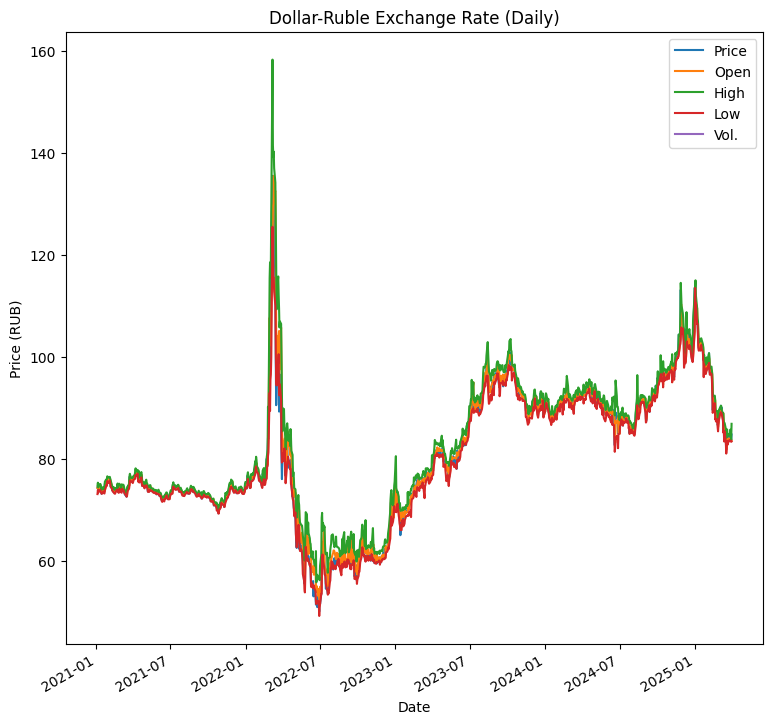

In [79]:
data.plot(title='Dollar-Ruble Exchange Rate (Daily)', figsize=(9, 9))
plt.ylabel('Price (RUB)')
plt.show()

### Data preprocessing

In [80]:
data = data.sort_index()
data = data.drop('Vol.', axis=1)
data['Change %'] = data['Change %'].str.replace('%', '')

data.head(10)

,Price,Open,High,Low,Change %
Date,,,,,
2021-01-04,74.2810,74.2707,74.6705,73.0611,0.67
2021-01-05,74.1100,74.5000,75.2937,73.8334,-0.23
2021-01-06,73.7075,74.1090,74.3652,73.3824,-0.54
2021-01-07,74.4381,73.9230,74.9850,73.5563,0.99
2021-01-08,73.8150,74.6998,74.9520,73.8150,-0.84
2021-01-11,74.5671,74.0000,75.0412,73.8790,1.02
2021-01-12,73.4466,74.7038,74.8620,73.4366,-1.50
2021-01-13,73.7375,73.4500,73.9812,73.3618,0.40
2021-01-14,73.1196,73.8450,74.1480,73.1088,-0.84


### Feature engineering

In [81]:
def feature_engineer(data):
    for lag in [1, 7, 30, 365]:
        data[f'Price_lag_{lag}'] = data['Price'].shift(lag)

    data['Price_rolling_mean_7'] = data['Price'].rolling(7).mean()
    data['Price_rolling_std_7'] = data['Price'].rolling(7).std()

    data['curr_day'] = data.index.dayofyear
    data['fourier_sin'] = np.sin(2 * np.pi * data['curr_day'] / 365)
    data['fourier_cos'] = np.cos(2 * np.pi * data['curr_day'] / 365)

    data['cur_week_day'] = data.index.dayofweek
    data['month'] = data.index.month
    
    data = data.dropna()

    return data

In [82]:
data = feature_engineer(data)

In [83]:
data = data.dropna()
data.head(10)

,Price,Open,High,Low,Change %,Price_lag_1,Price_lag_7,Price_lag_30,Price_lag_365,Price_rolling_mean_7,Price_rolling_std_7,curr_day,fourier_sin,fourier_cos,cur_week_day,month
Date,,,,,,,,,,,,,,,,
2022-05-27,64.000,64.925,69.5165,62.7125,2.94,62.175,62.250,78.250,74.2810,59.600000,3.279958,147,0.573772,-0.819015,4,5
2022-05-30,61.500,66.525,69.1030,60.3085,-3.91,64.000,62.100,78.625,74.1100,59.514286,3.210849,150,0.530730,-0.847541,0,5
2022-05-31,60.250,63.875,65.2530,60.0125,-2.03,61.500,59.500,78.250,73.7075,59.621429,3.222784,151,0.516062,-0.856551,1,5
2022-06-01,61.000,61.225,65.8840,60.4375,1.24,60.250,56.075,79.750,74.4381,60.325000,2.833615,152,0.501242,-0.865307,2,6
2022-06-02,60.875,64.500,67.4790,60.3500,-0.20,61.000,55.500,78.375,73.8150,61.092857,1.873984,153,0.486273,-0.873807,3,6
2022-06-03,60.860,63.500,65.3915,59.9000,-0.02,60.875,57.850,74.875,74.5671,61.522857,1.245973,154,0.471160,-0.882048,4,6
2022-06-06,59.125,63.500,64.4090,59.0500,-2.85,60.860,62.175,72.525,73.4466,61.087143,1.489418,157,0.425000,-0.905193,0,6
2022-06-07,59.250,61.375,63.3805,59.3125,0.21,59.125,64.000,73.125,73.7375,60.408571,0.910800,158,0.409356,-0.912375,1,6
2022-06-08,58.000,62.500,63.3130,58.3955,-2.11,59.250,61.500,71.250,73.1196,59.908571,1.142901,159,0.393590,-0.919286,2,6


### Split data

In [84]:
y = data['Price']
X = data.drop('Price', axis=1)

In [85]:
y.size

743

In [86]:
X.shape

(743, 15)

### Train LightGBM, CatboostGBM

LightGBM

In [87]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1
}

In [88]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)

In [89]:
rmse_scores = []
feature_importances = pd.DataFrame(index=X.columns)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=1000)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    print(f'Fold {fold+1} RMSE: {rmse}')
    
    fold_importance = pd.Series(model.feature_importance(), index=X.columns)
    feature_importances[f'fold_{fold+1}'] = fold_importance

print(f'Mean RMSE: {np.mean(rmse_scores)}')

Fold 1 RMSE: 12.85169954663537
Fold 2 RMSE: 14.32846804691443
Fold 3 RMSE: 1.0223669229935801
Fold 4 RMSE: 0.6428805313385405
Fold 5 RMSE: 4.439617219875131
Mean RMSE: 6.657006453551411


Catboost

In [90]:
cat_rmse_scores = []
cat_preds = np.zeros(len(X_scaled))

In [91]:
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    cat_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        use_best_model=True
    )
    
    y_pred = cat_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    cat_rmse_scores.append(rmse)
    print(f'CatBoost Fold {fold+1} RMSE: {rmse}')
    
    cat_preds[val_idx] = y_pred

print(f'CatBoost Mean RMSE: {np.mean(cat_rmse_scores)}')

0:	learn: 2.8861459	test: 15.1987666	best: 15.1987666 (0)	total: 1.48ms	remaining: 1.48s
100:	learn: 0.3883406	test: 12.8657547	best: 12.8657547 (100)	total: 89.1ms	remaining: 793ms
200:	learn: 0.1460964	test: 12.6388500	best: 12.6388389 (198)	total: 178ms	remaining: 708ms
300:	learn: 0.0798490	test: 12.5927952	best: 12.5917907 (285)	total: 267ms	remaining: 620ms
400:	learn: 0.0479622	test: 12.5791190	best: 12.5790383 (387)	total: 355ms	remaining: 531ms
500:	learn: 0.0286240	test: 12.5759237	best: 12.5753107 (470)	total: 442ms	remaining: 440ms
600:	learn: 0.0176154	test: 12.5695301	best: 12.5693219 (595)	total: 528ms	remaining: 350ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.56913222
bestIteration = 614

Shrink model to first 615 iterations.
CatBoost Fold 1 RMSE: 12.569132410953303
0:	learn: 8.1304301	test: 25.5539837	best: 25.5539837 (0)	total: 1.8ms	remaining: 1.79s
100:	learn: 0.5696478	test: 18.4746319	best: 18.4746319 (100)	total: 154ms	remaining: 1.37s


### LSTM

In [92]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                               shape=(input_shape[-1], 1),
                               initializer='random_normal',
                               trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W))
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

In [93]:
def lstm(input_shape):
    inputs = Input(shape=input_shape)
    
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    lstm_out = Dropout(0.2)(lstm_out)
    
    attention_out = AttentionLayer()(lstm_out)
    
    dense = Dense(32, activation='relu')(attention_out)
    output = Dense(1)(dense)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [94]:
model = lstm((seq_length, X_scaled.shape[1]))
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [5]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

NameError: name 'model' is not defined

In [71]:
y_pred_lstm = model.predict(X_test)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print(f'LSTM with Attention RMSE: {rmse_lstm}')

ValueError: Input numpy.ndarray or list must be 2 dimensional

In [70]:
X_lstm_full, _ = create_sequences(X_scaled, y.values, seq_length)
lstm_preds = model.predict(X_lstm_full).flatten()
lstm_preds_full = np.full(len(X_scaled), np.nan)
lstm_preds_full[seq_length:] = lstm_preds

ValueError: Input numpy.ndarray or list must be 2 dimensional

### Visualisation

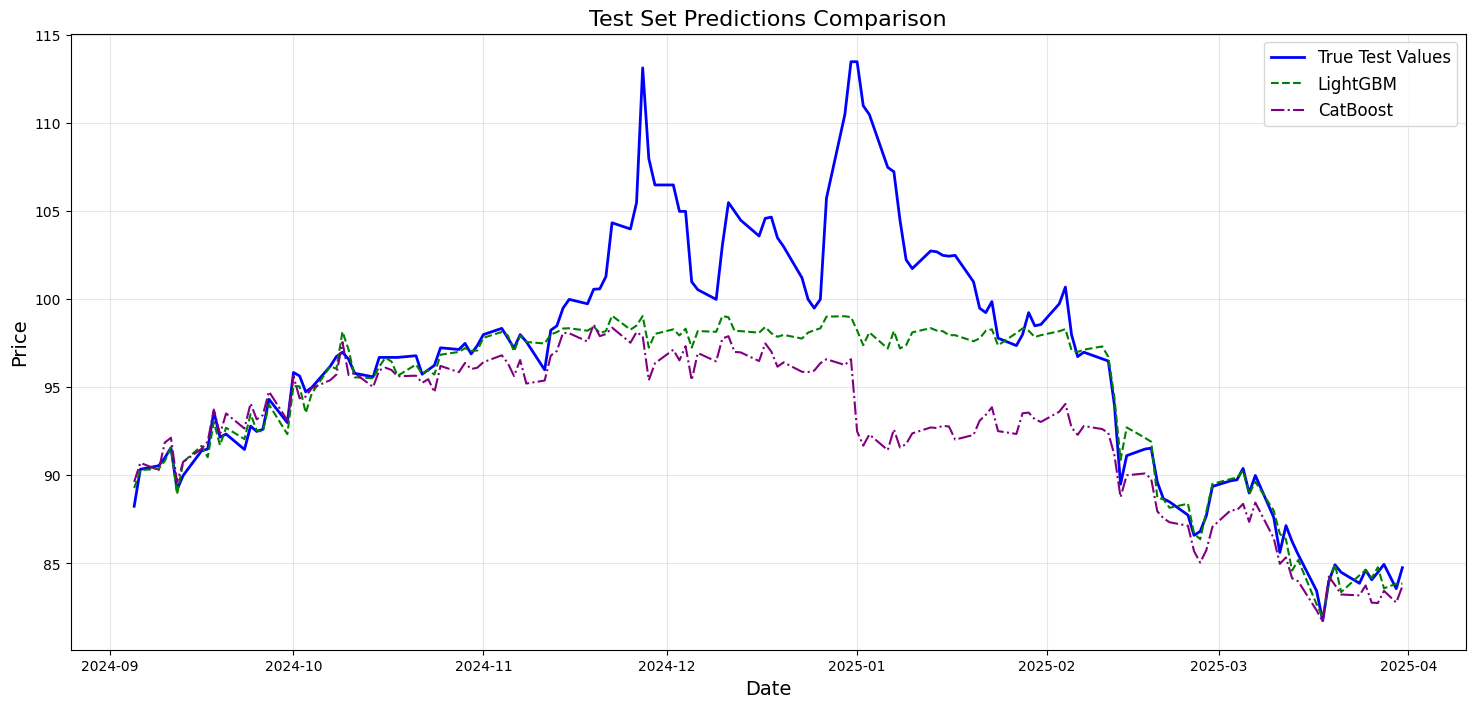

In [69]:
test_start = int(0.8 * len(data))
test_dates = data.index[test_start:]

plt.figure(figsize=(18, 8))

plt.plot(test_dates, y.iloc[test_start:], label='True Test Values', color='blue', linewidth=2)
plt.plot(test_dates, lgb_preds[test_start:], label='LightGBM', color='green', linestyle='--')
plt.plot(test_dates, cat_preds[test_start:], label='CatBoost', color='purple', linestyle='-.')

plt.title('Test Set Predictions Comparison', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()